**Introduction**

In this notebook, we would like to show an example of how to run code on a quantum computer. Coding a quantum computer can be done via an API using the Python language.

Depending on the task, coding a quantum computer can be done at a very abstract level, e.g., by simply calling some already implemented well-known algorithms. Alternatively, one can code very close to the circuit level, specifying operations at the qubit and gate level.

In this notebook, we see an example of rather abstract coding. We would like to apply some popular Quantum Machine Learning (QML) methods known as Quantum Kernel Methods to an anomaly detection problem. Quantum Kernel Methods are analogous to classic Kernel Methods, with the only difference being the kernel matrix is computed via a quantum circuit. For more information on classic Kernel Methods see https://en.wikipedia.org/wiki/Kernel_method.

The notebook is structured as follows:

- In the first part, we explain the anomaly detection problem we want to solve.
- Second, we fit a one-class support vector machine (OCSVM) with a classic (Gaussian) kernel to our data and evaluate the performance.
- Third, we fit an OCSVM with a quantum kernel, which is computed on a local simulator. We then evaluate the performance and compare it to the classical case.
- Finally, we connect to the IBM cloud and fit an OCSVM with a quantum kernel computed on a real quantum computer.

We will see that to work with quantum computers, all we have to do is to simply add a few lines of code.

If you don’t know anything about machine learning or coding, don’t worry. All you have to understand from this notebook is that, in some circumstances, coding on a quantum computer requires very little additional effort and doesn’t necessarily require a deep understanding of quantum computing.



**The problem and the dataset**

We will work with black-and-white handwritten images from the MNIST dataset. We will present our model with 150 images and ask it to detect the ones which are anomalous, without giving any indication of what "anomalous" means. In data science terms, this is an unsupervised in-sample anomaly detection task, as we will not provide any labels.

To get a sense of what the model has to do, can you find the three anomalous images in the picture below?

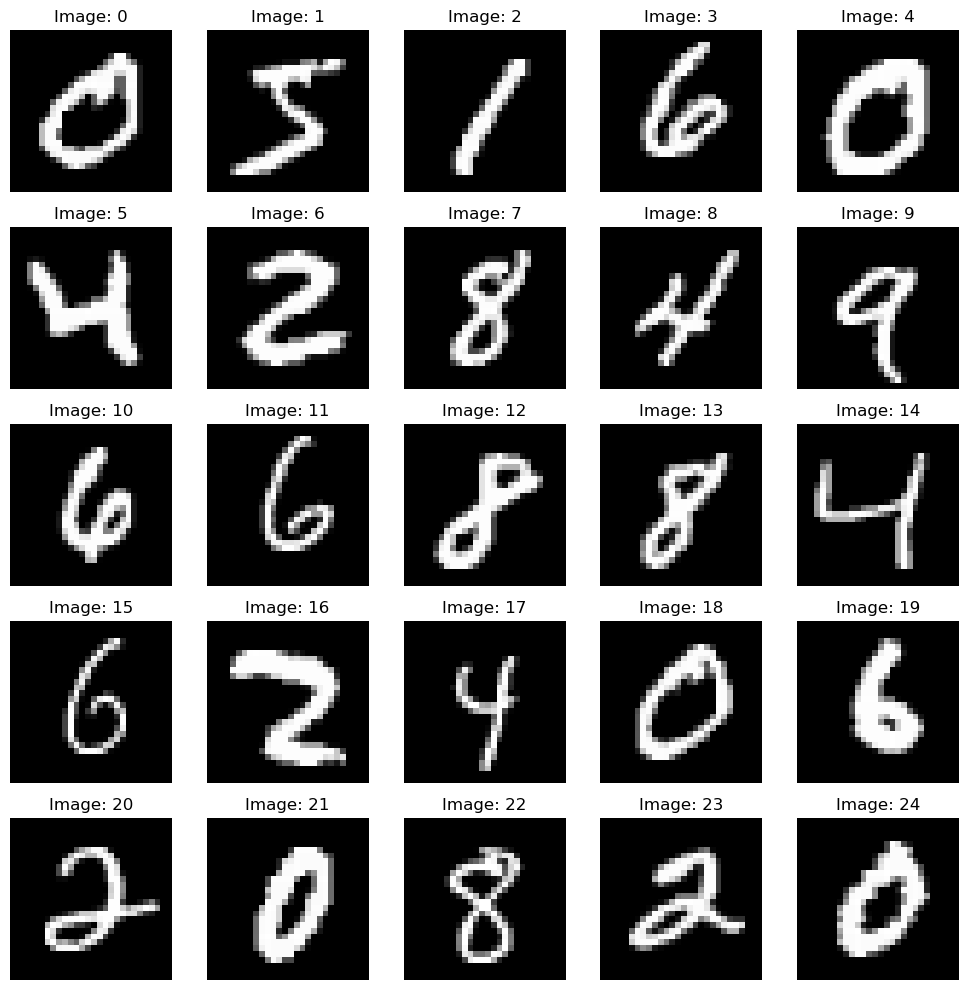

In [3]:
from data_loader import *
plot_mnist_examples()  

As you might have guessed, most of the images represent even digits (0, 2, 4, 6, 8), and only some represent odd digits. For a human, it would therefore be intuitive to classify images of odd digits as anomalous.

However, this might be a relatively difficult task for a machine learning model because of the following reasons:
- Limited number of examples.
- Lack of labels (the model doesn't know the images represent digits and has to somehow learn this).
- Normal data are multimodal (images corresponding to distinct even numbers, e.g., 2 and 4, are different from each other).

Additionally, both for humans and for a model, there might be other characteristics that render an image anomalous, e.g., some are thinner or thicker.

Each image is composed of 784 pixels, with each pixel being independent of the others. This is too much information for a small model to work with effectively. Therefore, we will process the images to significantly reduce their dimensions. Mathematically, we will apply a well-known dimensionality reduction technique called UMAP to represent each image as a vector (point) in a 3D space (the dimension 3 has been chosen for visual ease).

This dimensionality reduction technique is chosen because images that are similar (i.e., representing the same digit) are represented by points that are close together, as can be seen in the image below.

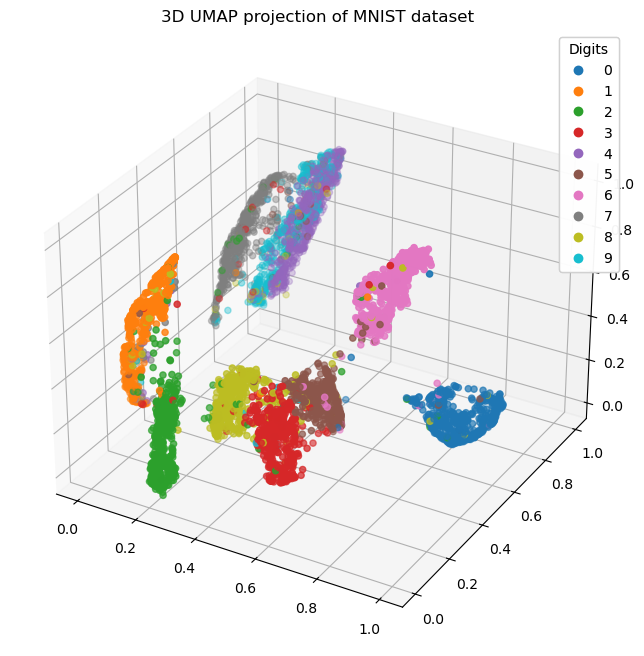

In [2]:
df_train_selected_reduced = sample_and_reduce_mnist_data()
visualize_mnist_data(df_train_selected_reduced, df_train_selected_reduced['label'], n_classes = 10)

As mentioned before, we want to work with 150 images. Most of them should represent even numbers, with only a few representing odd numbers. We sample the data accordingly and obtain the dataset displayed in the image below.

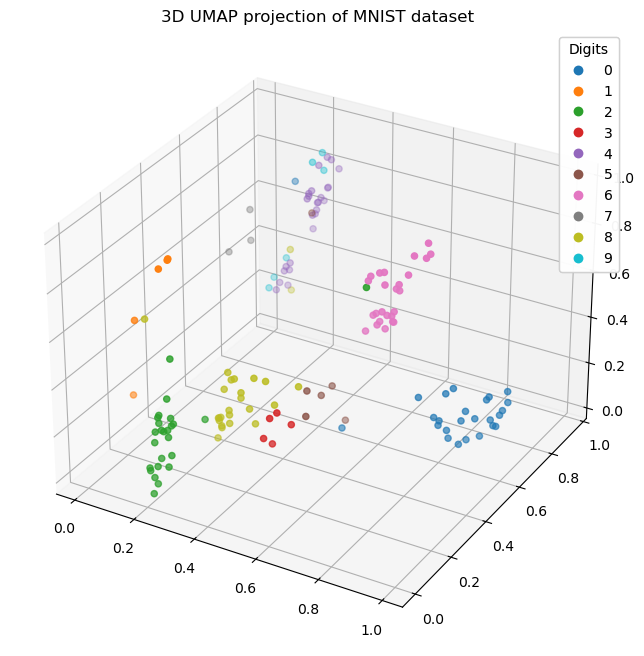

In [3]:
X, y, original_label = sample_mnist_data(df_train_selected_reduced, sample_size=150, 
                                         ratio_outliers = 0.2, random_state=42, number_of_features = 3)
visualize_mnist_data(X, original_label, n_classes = 10)

As one can see, most of the data represent even numbers (these are considered normal data - blue), while a few represent odd numbers (these are considered anomalies - yellow). We would like the model to learn this classification as effectively as possible by simply looking at the position of the points, without knowing the labels/colors.

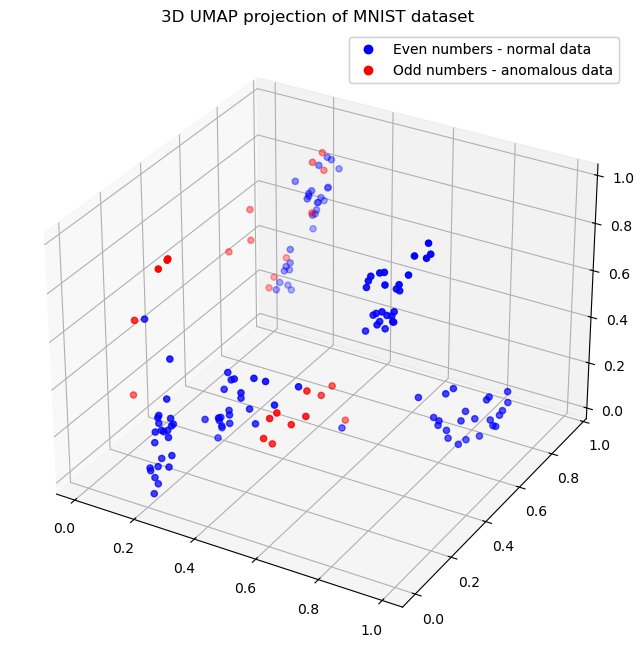

In [4]:
visualize_mnist_data(X, y, n_classes = 2)

**Classic model**

We start by trying a classic model. Fitting a classic model is relatively easy; one can simply use the popular scikit-learn Python library and apply a ready-made implementation of OCSVM.

One can see that the model does relatively well in predicting the anomalies. The performance metric to look at in this case is the F1 score. Other metrics are also reported. The image below displays the model predictions. One can compare it to the image to the left displaying the correct classification and see which points have been correctly classified and which ones have been incorrectly classified.

f1_score : 0.39285714285714285
accuracy : 0.7733333333333333
recall : 0.44
precision : 0.3548387096774194


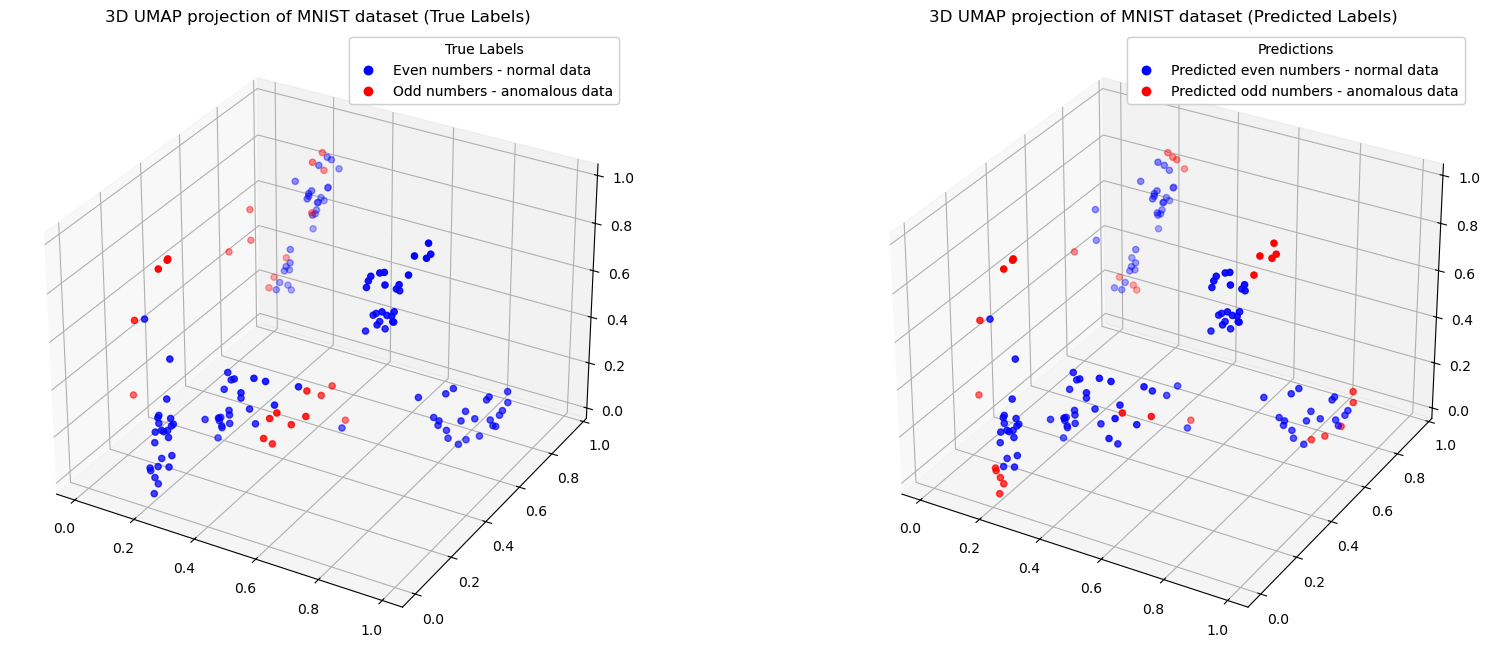

In [5]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Train a one-class SVM with RBF kernel
classic_oc_svm = OneClassSVM(kernel='rbf', nu=0.2)
classic_oc_svm.fit(X)

#compute predictions
classic_predictions = ((classic_oc_svm.predict(X) - 1) * (-0.5)).astype(int)

#evaluate the results versus the real labels
print(f'f1_score : {f1_score(y, classic_predictions)}')
print(f'accuracy : {accuracy_score(y, classic_predictions)}')
print(f'recall : {recall_score(y, classic_predictions)}')
print(f'precision : {precision_score(y, classic_predictions)}')


#plot the predictions
compare_predictions_and_labels(X, y, classic_predictions)

**Simulated Quantum Model**

We will now fit an OCSVM with a quantum kernel to the data. The kernel will not be calculated by a quantum computer, but by a local simulator.

One can observe that only very few additional lines of code are needed. One simply needs to specify the parameters of a predefined quantum kernel.

Note that the results produced by the quantum-simulated OCSVM (all evaluation metrics are higher) are better than those produced by the classic OCSVM.

f1_score : 0.5
accuracy : 0.8133333333333334
recall : 0.56
precision : 0.45161290322580644


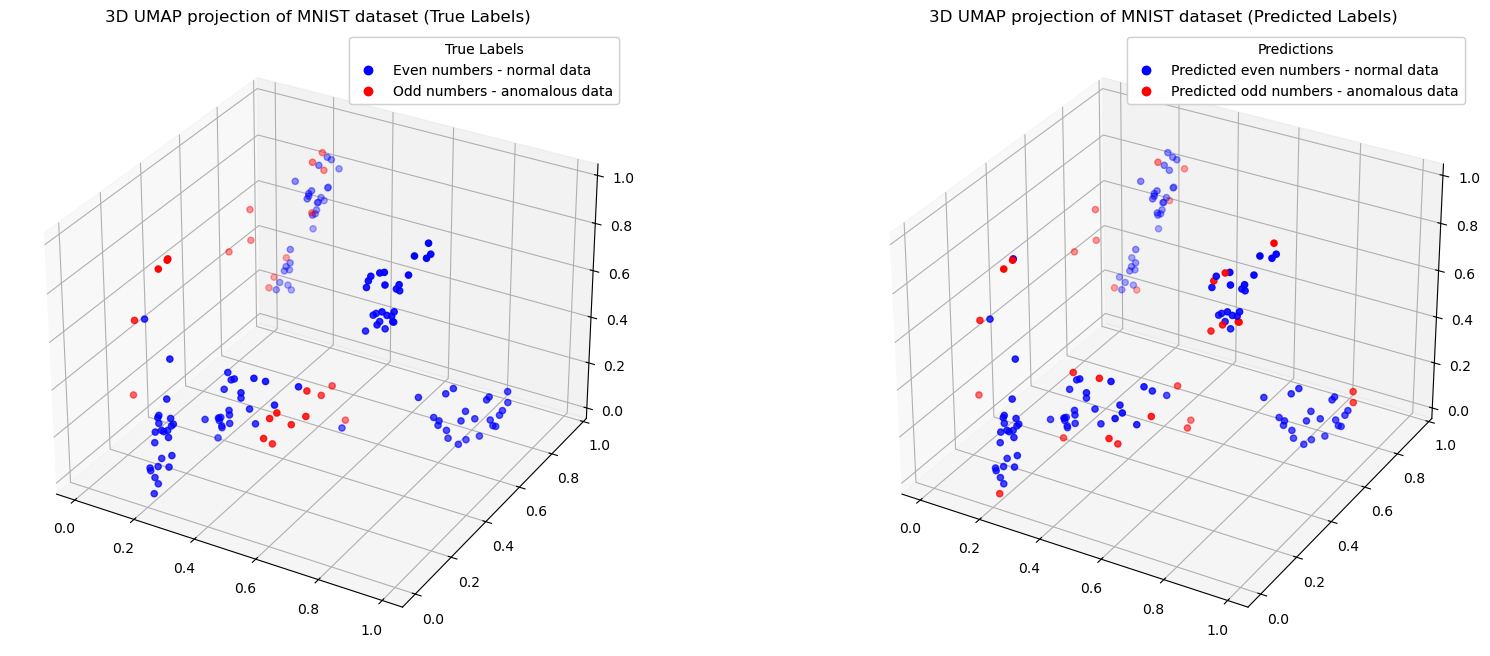

In [6]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Create a quantum feature map and specify parameters
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
qkernel = FidelityQuantumKernel(feature_map=feature_map)

# Rescale the data to the range (0, pi/2) for data are encoded as angles in the quantum computer 
scaler = MinMaxScaler(feature_range=(0, np.pi/2))
scaler.fit(X)
X_scaled = scaler.transform(X)

# Compute the kernel matrix using the quantum kernel  - this happens under the hood in the application of the classic OCSVM
kernel_matrix = qkernel.evaluate(X_scaled)

########################################################################################################################################################

# Train a one-class SVM with the precomputed kernel matrix
quantum_simulated_oc_svm = OneClassSVM(kernel='precomputed', nu=0.2)
quantum_simulated_oc_svm.fit(kernel_matrix)

#compute predictions
quantum_sim_predictions = ((quantum_simulated_oc_svm.predict(kernel_matrix) - 1) * (-0.5)).astype(int)

#evaluate the results versus the real labels
print(f'f1_score : {f1_score(y, quantum_sim_predictions)}')
print(f'accuracy : {accuracy_score(y, quantum_sim_predictions)}')
print(f'recall : {recall_score(y, quantum_sim_predictions)}')
print(f'precision : {precision_score(y, quantum_sim_predictions)}')

#plot the predictions
compare_predictions_and_labels(X, y, quantum_sim_predictions)

**Quanutm Model**

Now we fit an OCSVM with a quantum kernel to the data. In this case, the kernel is computed by a real quantum computer.

All we have to do in this case (in addition to the simulated quantum case) is to first connect to the IBM cloud (https://www.ibm.com/quantum) and specify some run and circuit optimization parameters.

Note that the obtained results are better than the results obtained classically. 

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

#input IBM quantum account credentials

#QiskitRuntimeService.save_account(
#  token="xxx",     #input your token here
#  channel="ibm_quantum", # `channel` distinguishes between different account types
#    overwrite=True
#)

C:\Users\melch\.conda\envs\qpu_demo\Lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


f1_score : 0.34615384615384615
accuracy : 0.7733333333333333
recall : 0.36
precision : 0.3333333333333333


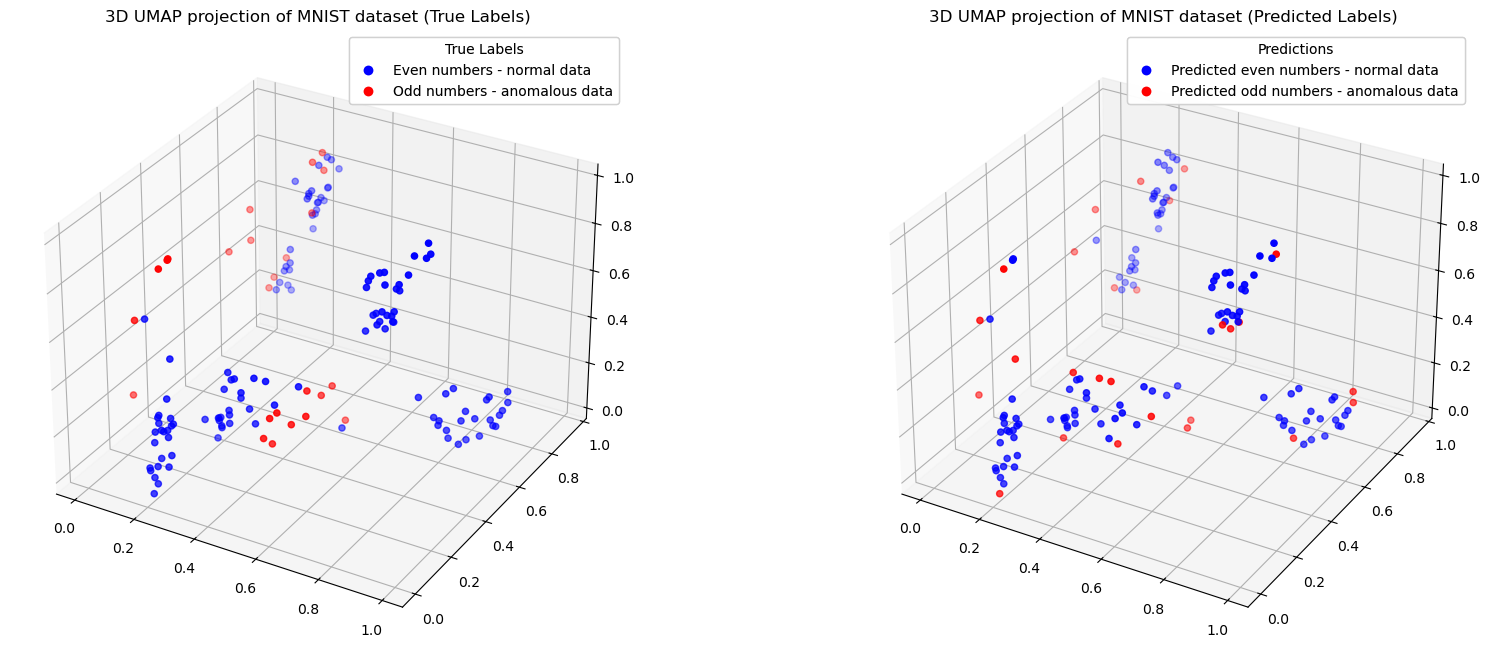

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, SamplerV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#connecting to the IBM cloud  and selecting a backend (a quantum machine)
service = QiskitRuntimeService()
#backend = service.least_busy(simulator=False, operational=True)  # to select the least busy quantum machine available
backend = GenericBackendV2(num_qubits=3, seed = 1)                         # to connect to a simulator in the IBM quantum cloud
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)  #specify desired level of circuit optimization

sampler = SamplerV2(mode=session)
fidelity = ComputeUncompute(sampler=sampler, pass_manager=pass_manager)

########################################################################################################################################################

# Create a quantum feature map and specify parameters
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
qkernel = FidelityQuantumKernel(feature_map = feature_map, fidelity = fidelity)

# Rescale the data to the range (0, pi/2) for data are encoded as angles in the quantum computer 
scaler = MinMaxScaler(feature_range=(0, np.pi/2))
scaler.fit(X)
X_scaled = scaler.transform(X)

# Compute the kernel matrix using the quantum kernel  - this happens under the hood in the application of the classic OCSVM
kernel_matrix = qkernel.evaluate(X_scaled)

########################################################################################################################################################

# Train a one-class SVM with the precomputed kernel matrix
quantum_simulated_oc_svm = OneClassSVM(kernel='precomputed', nu=0.2)
quantum_simulated_oc_svm.fit(kernel_matrix)

#compute predictions
quantum_sim_predictions = ((quantum_simulated_oc_svm.predict(kernel_matrix) - 1) * (-0.5)).astype(int)

#evaluate the results versus the real labels
print(f'f1_score : {f1_score(y, quantum_sim_predictions)}')
print(f'accuracy : {accuracy_score(y, quantum_sim_predictions)}')
print(f'recall : {recall_score(y, quantum_sim_predictions)}')
print(f'precision : {precision_score(y, quantum_sim_predictions)}')

#plot the predictions
compare_predictions_and_labels(X, y, quantum_sim_predictions)

Note that in order not to consume precious and expensive QPU time on the IBM cloud we ar actually running the cell above on a simulator on the IBM cloud (this is visible by the two line of code 
#backend = service.least_busy(simulator=False, operational=True)  # to select the least busy quantum machine available
backend = GenericBackendV2(num_qubits=3, seed = 1)                         # to connect to a simulator in the IBM quantum cloud). 
In this way we could demonstrate the connection to the IBM cloud and the correctness of the circuits without consuming QPU time.  

If you are curious about running the code on a real IBM QPU without consuming too much of your free tier QPU time, you could reduce the number of points in your sample before submitting the job. An example is in the code below. 

Obviously, if you take a very small number of points, you should not expect good performance.  



In [8]:
# sampling few points from our input data
np.random.seed(1)
number_of_points = 12

idx = np.random.choice(np.arange(len(X)), number_of_points, replace=False)

X_undersampled =  X.iloc[idx]
y_undersampled =  y.iloc[idx]

In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, SamplerV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#connecting to the IBM cloud  and selecting a backend (a quantum machine)
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)  # to select the least busy quantum machine available
#backend = GenericBackendV2(num_qubits=3, seed = 1)                         # to connect to a simulator in the IBM quantum cloud
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)  #specify desired level of circuit optimization

sampler = SamplerV2(mode=session)
fidelity = ComputeUncompute(sampler=sampler, pass_manager=pass_manager)

########################################################################################################################################################

# Create a quantum feature map and specify parameters
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
qkernel = FidelityQuantumKernel(feature_map = feature_map, fidelity = fidelity)

# Rescale the data to the range (0, pi/2) for data are encoded as angles in the quantum computer 
scaler = MinMaxScaler(feature_range=(0, np.pi/2))
scaler.fit(X_undersampled)
X_scaled = scaler.transform(X_undersampled)

# Compute the kernel matrix using the quantum kernel  - this happens under the hood in the application of the classic OCSVM
kernel_matrix = qkernel.evaluate(X_scaled)

########################################################################################################################################################



f1_score : 0.5
accuracy : 0.6666666666666666
recall : 1.0
precision : 0.3333333333333333


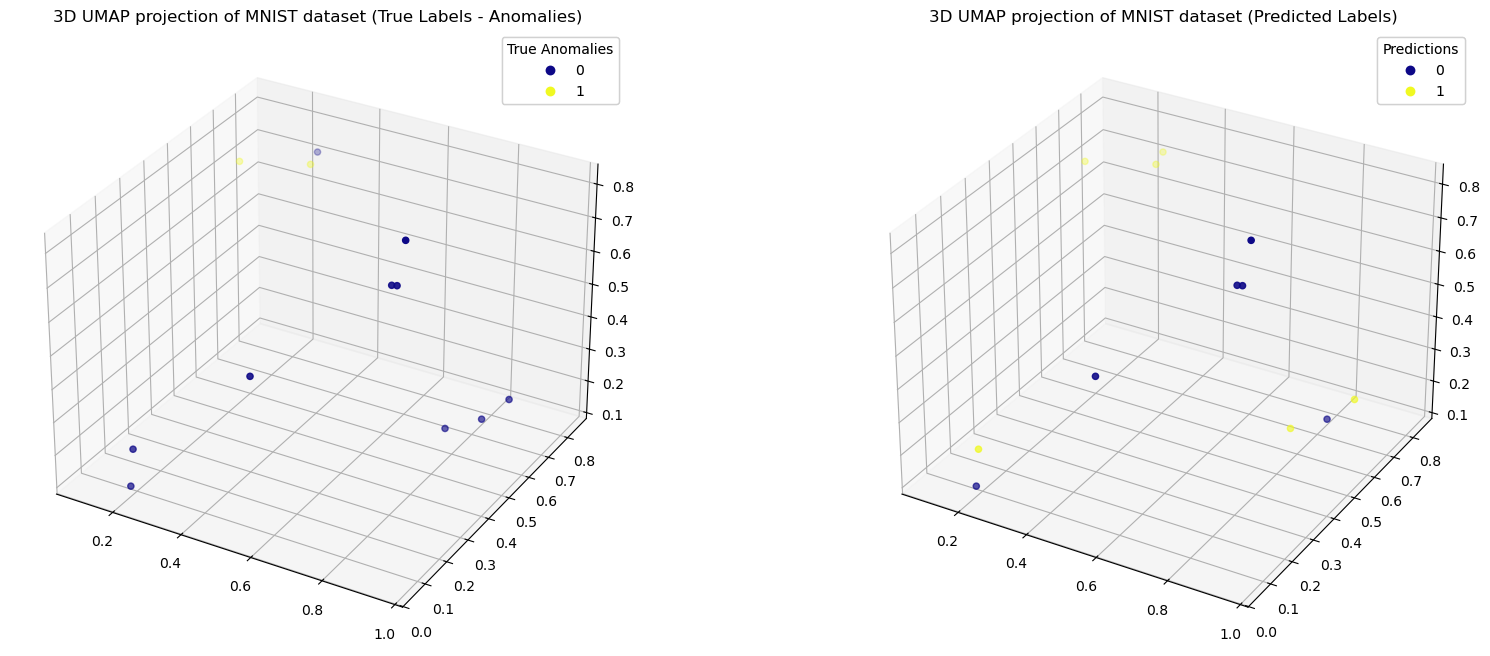

In [32]:
# Train a one-class SVM with the precomputed kernel matrix
quantum_simulated_oc_svm = OneClassSVM(kernel='precomputed', nu=0.2)
quantum_simulated_oc_svm.fit(kernel_matrix)

#compute predictions
quantum_sim_predictions = ((quantum_simulated_oc_svm.predict(kernel_matrix) - 1) * (-0.5)).astype(int)

#evaluate the results versus the real labels
print(f'f1_score : {f1_score(y_undersampled, quantum_sim_predictions)}')
print(f'accuracy : {accuracy_score(y_undersampled, quantum_sim_predictions)}')
print(f'recall : {recall_score(y_undersampled, quantum_sim_predictions)}')
print(f'precision : {precision_score(y_undersampled, quantum_sim_predictions)}')

#plot the predictions
compare_predictions_and_labels(X_undersampled, y_undersampled, quantum_sim_predictions)